In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 

sys.path.insert(0, '../../../../scripts/')
import dataframe_analysis as dfa
import create_AR_DeployInst as cdi
import dakota_output as oup

In [98]:
#General plotting variables
metrics = {'enr_u':'Uranium Mass', 'haleu':'HALEU Mass', 'swu':'Total SWU', 
          'haleu_swu':'HALEU SWU', 'waste':'SNF', 'feed':'HALEU Feed'}
colors = ['tab:blue', 'tab:orange','tab:purple']
markers = ['d','o','*', 's','v','P']

## Transition Start Time
The transition start time ranges from times tep 721-901, in increments of 3 months.

The first part of the analysis compares the results of using the DeployInst and the ManagerInst in Cyclus, comparing 
the results from different methods to deploy the advanced reactors. The second part of the analysis is for just the
results from deploying advanced reactors with the DeployInst, with these results in publsihed literature.

In [99]:
ts_file = "transition_start/transition_start.dat"
ts_data = pd.read_csv(ts_file, sep="\s+",header=0)
ts_data['Year'] = ts_data['ts']/12 + 1965

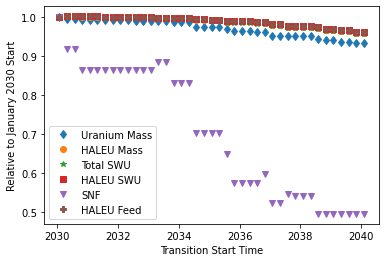

In [119]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(ts_data['Year'][20:], ts_data[key][20:]/ts_data[key][20],label=metrics[key], 
            linestyle='None', marker =markers[index])
plt.xlabel('Transition Start Time')
plt.legend()
plt.ylabel('Relative to January 2030 Start')
plt.savefig('figures/ts.pdf')

In [101]:
ts_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = ts_data[key].min()
    maximum = ts_data[key].max()
    average = ts_data[key].mean()
    std = ts_data[key].std()
    ts_results.loc[len(ts_results)] = [metrics[key], minimum, maximum, average, std]

In [102]:
ts_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Uranium Mass,3.038713e+07,3.279658e+07,3.198724e+07,7.961829e+05
1,HALEU Mass,2.952153e+07,3.080642e+07,3.050072e+07,3.793288e+05
2,Total SWU,1.019537e+09,1.066378e+09,1.055364e+09,1.449935e+07
3,HALEU SWU,1.013695e+09,1.055046e+09,1.045332e+09,1.194150e+07
4,SNF,1.165054e+06,2.594954e+06,1.950656e+06,5.412501e+05
5,HALEU Feed,8.808064e+08,9.169635e+08,9.084585e+08,1.046392e+07


## LWR Lifetime
Vary the percent of LWRs that operate for 80 years, with the other reactors operating for 60 years.
Percent varies between 0-50% in 5% increments

In [148]:
lwr_file = "lwr_lifetime/lwr_lifetime.dat"
lwr_data = pd.read_csv(lwr_file, sep="\s+",header=0)

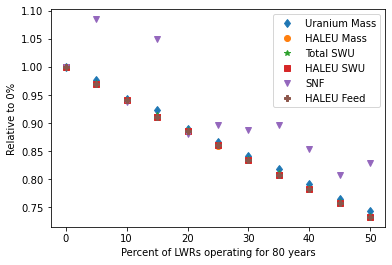

In [149]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(lwr_data['lwr'], lwr_data[key]/lwr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent of LWRs operating for 80 years')
plt.legend()
plt.ylabel('Relative to 0%')
plt.savefig('figures/lwr.pdf')

In [152]:
lwr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = lwr_data[key].min()
    maximum = lwr_data[key].max()
    average = lwr_data[key].mean()
    std = lwr_data[key].std()
    lwr_results.loc[len(lwr_results)] = [metrics[key], minimum, maximum, average, std]

In [153]:
lwr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Uranium Mass,2.338014e+07,3.144457e+07,2.731690e+07,2.691743e+06
1,HALEU Mass,2.204940e+07,3.007378e+07,2.592959e+07,2.642460e+06
2,Total SWU,7.638275e+08,1.039003e+09,8.972937e+08,9.077549e+07
3,HALEU SWU,7.548464e+08,1.029751e+09,8.879308e+08,9.045370e+07
4,SNF,1.559769e+06,2.095857e+06,1.778281e+06,1.726611e+05
5,HALEU Feed,6.560773e+08,8.949957e+08,7.717277e+08,7.861888e+07


## Build Share
The new build share is specified for a single reactor type ranges from 0-50% 
in increments of 5%. This is analysis is performed 3 times, specifying the 
build share for each type of reactor. 

### Xe-100

In [107]:
xe100_file = "build-share/xe-100/xe100_build.dat"
xe100_data = pd.read_csv(xe100_file, sep="\s+",header=0)

Text(0, 0.5, 'Relative to 10% build share')

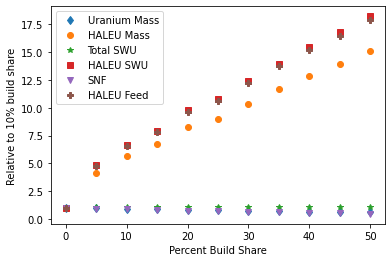

In [134]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(xe100_data['xe100'], xe100_data[key]/xe100_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 10% build share')
#plt.savefig('figures/xe100.pdf')

In [132]:
xe100_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = xe100_data[key].min()
    maximum = xe100_data[key].max()
    average = xe100_data[key].mean()
    std = xe100_data[key].std()
    xe100_results.loc[len(xe100_results)] = [metrics[key], minimum, maximum, average, std]

In [133]:
xe100_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Uranium Mass,8.251012e+07,1.392499e+08,1.098766e+08,1.863429e+07
1,HALEU Mass,1.265608e+06,1.915820e+07,1.137090e+07,5.523786e+06
2,Total SWU,9.670149e+08,1.079362e+09,1.048208e+09,3.063436e+07
3,HALEU SWU,3.576010e+07,6.518004e+08,3.833947e+08,1.902994e+08
4,SNF,5.685063e+07,1.226529e+08,8.785627e+07,2.129340e+07
5,HALEU Feed,3.170211e+07,5.668484e+08,3.337115e+08,1.653012e+08


### MMR 

In [135]:
mmr_file = "build-share/mmr/mmr_build.dat"
mmr_data = pd.read_csv(mmr_file, sep="\s+",header=0)

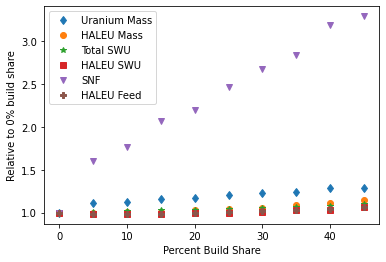

In [136]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(mmr_data['mmr'], mmr_data[key]/mmr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 0% build share')
plt.savefig('figures/mmr.pdf')

In [137]:
mmr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = mmr_data[key].min()
    maximum = mmr_data[key].max()
    average = mmr_data[key].mean()
    std = mmr_data[key].std()
    mmr_results.loc[len(mmr_results)] = [metrics[key], minimum, maximum, average, std]

In [138]:
mmr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Uranium Mass,3.716690e+07,4.787664e+07,4.388128e+07,3.300198e+06
1,HALEU Mass,2.862694e+07,3.311219e+07,3.021161e+07,1.509320e+06
2,Total SWU,1.051471e+09,1.155774e+09,1.096109e+09,3.365441e+07
3,HALEU SWU,9.793799e+08,1.056129e+09,1.003852e+09,2.481448e+07
4,SNF,7.325239e+06,2.409842e+07,1.690969e+07,5.331455e+06
5,HALEU Feed,8.512843e+08,9.242944e+08,8.749986e+08,2.368330e+07


### VOYGR

In [154]:
voygr_file = "build-share/voygr/voygr_build.dat"
voygr_data = pd.read_csv(voygr_file, sep="\s+",header=0)

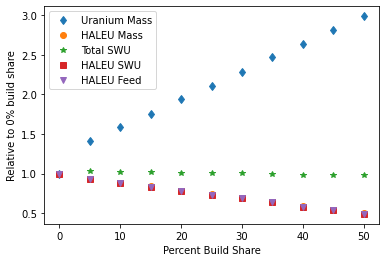

In [163]:
plt.figure
for index, key in enumerate(['enr_u','haleu','swu','haleu_swu','feed']): 
    plt.plot(voygr_data['voygr'], voygr_data[key]/voygr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 0% build share')
plt.savefig('figures/voygr.pdf')

In [156]:
voygr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = voygr_data[key].min()
    maximum = voygr_data[key].max()
    average = voygr_data[key].mean()
    std = voygr_data[key].std()
    voygr_results.loc[len(voygr_results)] = [metrics[key], minimum, maximum, average, std]

In [157]:
voygr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Uranium Mass,3.151239e+07,9.415978e+07,6.587311e+07,1.952721e+07
1,HALEU Mass,1.560599e+07,3.151239e+07,2.330087e+07,5.201885e+06
2,Total SWU,1.055805e+09,1.106028e+09,1.078381e+09,1.609978e+07
3,HALEU SWU,5.256461e+08,1.074401e+09,7.910611e+08,1.794220e+08
4,SNF,1.263448e+06,6.998801e+07,3.825922e+07,2.172977e+07
5,HALEU Feed,4.575741e+08,9.341810e+08,6.880976e+08,1.558353e+08
